In [1]:
import pandas as pd
import sqlite3
import re

from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [2]:
con = sqlite3.connect('data.db')

cur = con.cursor()

articles = [*cur.execute("select * from article;")]
companies = [*cur.execute("select * from company;")]
a2c = [*cur.execute("select * from article_company;")]

con.close()

In [3]:
articles = pd.DataFrame(articles, columns=['idx', 'title', 'text', 'href', 'date']).set_index('idx')
a2c = pd.DataFrame(a2c, columns=['article_id', 'company_id'])
companies = pd.DataFrame(companies, columns=['idx', 'name', 'ticker']).set_index('idx')

In [4]:
articles['text_size'] = articles['text'].apply(lambda x: len(x.split()))

In [50]:
articles.sample(5)

,title,text,href,date,text_size
idx,,,,,
188424,S&P 500 stock repurchases rose 22% in latest qtr,Companies in the Standard & Poor's 500 index s...,https://www.marketwatch.com/story/sp-500-stock...,2011-09-20,155
214495,"10 fallen sports heroes, led by Lance Armstrong",Lance Armstrong’s contract with Nike Inc. was ...,https://www.marketwatch.com/story/10-fallen-sp...,2012-10-22,551
250010,"PulteGroup Inc. stock rises Wednesday, outperf...",Shares of PulteGroup Inc. advanced 2.70% to $5...,https://www.marketwatch.com/story/pultegroup-i...,2021-04-28,141
193023,"Europe scores strong gains, led by miners, BASF",LONDON (MarketWatch) -- European shares posted...,https://www.marketwatch.com/story/miners-tech-...,2009-10-14,595
219623,Las Vegas Presses Its Luck in the Postpandemic...,Las Vegas is coming back to life.\nOn a Wednes...,https://www.marketwatch.com/articles/las-vegas...,2021-06-04,1387


In [39]:
articles.sort_values(by='text_size', ascending=False)

,title,text,href,date,text_size
idx,,,,,
54698,"Updates, advisories and surprises","Mazda profit up nearly sixteen-fold, outlook u...",https://www.marketwatch.com/story/updates-advi...,2006-07-27,20098
31282,"Updates, advisories and surprises",Standard Pacific quarterly profit surges 79% (...,https://www.marketwatch.com/story/updates-advi...,2005-07-28,19693
31755,"Updates, advisories and surprises",CORRECT: Emulex quarterly profit rises 15% (9:...,https://www.marketwatch.com/story/updates-advi...,2005-10-27,18698
31747,"Updates, advisories and surprises",Mazda announces record earnings for 2005 (11:0...,https://www.marketwatch.com/story/updates-advi...,2006-04-27,18175
25345,"Updates, advisories and surprises",Granite Contruction quarterly loss narrows (8:...,https://www.marketwatch.com/story/updates-advi...,2006-04-26,16484
...,...,...,...,...,...
119737,"Chevron up, but energy stocks drop",NEW YORK (MarketWatch) -- Shares of Chevron Co...,https://www.marketwatch.com/story/chevron-up-b...,2012-09-24,51
231392,Tech stocks try to edge upward in early trading,SAN FRANCISCO (MarketWatch) -- Tech stocks too...,https://www.marketwatch.com/story/tech-stocks-...,2012-05-07,51
192997,Intel hikes quarterly dividend 12.5%,NEW YORK (MarketWatch) -- Intel Corp. said Mon...,https://www.marketwatch.com/story/intel-hikes-...,2009-11-16,51


In [7]:
mask = articles['text_size'] < 10
articles.loc[mask, 'text_size'].value_counts()

0    5412
5      18
4      16
8      10
6      10
9       9
7       9
2       3
3       2
1       1
Name: text_size, dtype: int64

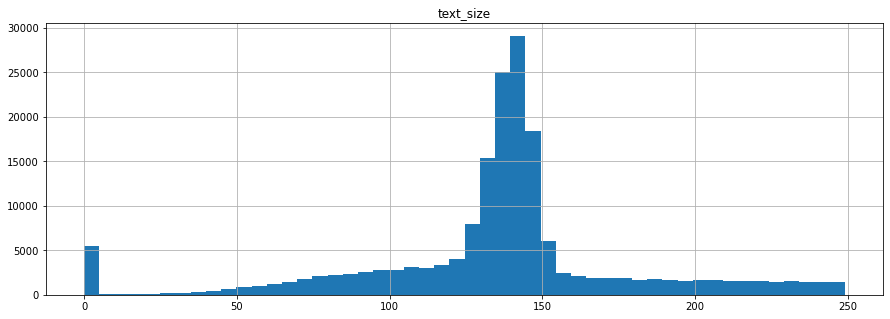

In [8]:
articles[articles['text_size'] < 250].hist(bins=50, figsize=(15,5));

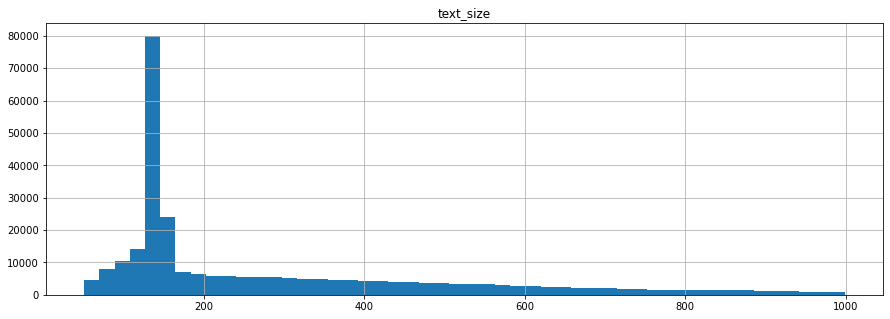

In [9]:
mask = articles['text_size'] > 50
articles = articles[mask]
articles[articles['text_size'] < 1000].hist(bins=50, figsize=(15,5));

In [51]:
example_id = 219623

article_text = articles.loc[example_id, 'text']
article_chunks = article_text.split('\n')

In [52]:
elements_to_pop = []

for i, chunk in enumerate(article_chunks):
    if re.search("\S*@\S*", chunk) != None or chunk == '':
        elements_to_pop.append(i)

for i in reversed(elements_to_pop):
    article_chunks.pop(i)

article_chunks

['Las Vegas is coming back to life.',
 'On a Wednesday evening last month, the casino was humming at the Venetian Resort on the Las Vegas Strip. Slot-machine players, some wearing masks, hoped to get lucky amid the faint smell of cigarette smoke. The machines were lined up close together, one after another.',
 'Upstairs at an Italian restaurant in a replica of Venice’s St. Mark’s Square, the tables were about half-full. “It’s getting better. We’re going to have conventions soon,” says Silvia Saucezo, a waitress there, adding that Fridays and Saturdays were the best nights for business.',
 'The pandemic hit Las Vegas hard in March 2020. Gambling is often resilient during economic downturns, but it’s hard to maintain business as usual when casinos are shut down for nearly three months. Convention business dried up, too. And with none of the buffets or signature shows open and lockdowns in place, leisure travel froze. Thousands of workers whose livelihood is tied to the 24/7 bustle of Sin

In [53]:
input_id_chunks = []
mask_chunks = []

for i in range(len(article_chunks)):
    token = tokenizer.encode_plus(article_chunks[i], add_special_tokens=False, return_tensors='pt')
    input_id_chunks.append(token['input_ids'][0])
    mask_chunks.append(token['attention_mask'][0])

In [54]:
input_id_chunks[0], mask_chunks[0]

(tensor([5869, 7136, 2003, 2746, 2067, 2000, 2166, 1012]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1]))

In [55]:
chunksize = 512
alpha = torch.tensor([101])
beta = torch.tensor([1])
input_tensors = []
mask_tensors = []

for i in range(len(input_id_chunks)):
    if len(input_id_chunks[i]) + len(alpha) < 512:
        alpha = torch.cat([alpha, input_id_chunks[i]])
        beta = torch.cat([beta, mask_chunks[i]])
    else:
        alpha = torch.cat([alpha, torch.tensor([102]), torch.tensor([0] * (chunksize - len(alpha) - 1))])
        beta = torch.cat([beta, torch.tensor([1]), torch.tensor([0] * (chunksize - len(beta) - 1))])
        
        input_tensors.append(alpha)
        mask_tensors.append(beta)
        
        alpha = torch.tensor([101])
        beta = torch.tensor([1])

In [2]:
input_ids = torch.stack(input_tensors)
attention_mask = torch.stack(mask_tensors)

input_dict = {
    'input_ids': input_ids.long(),
    'attention_mask': attention_mask.int()
}
input_dict

NameError: name 'torch' is not defined

In [1]:
outputs = model(**input_dict)
probs = torch.nn.functional.softmax(outputs[0], dim=-1)
probs

NameError: name 'model' is not defined

In [37]:
probs = probs.mean(dim=0)
probs

tensor([0.0293, 0.9508, 0.0199], grad_fn=<MeanBackward1>)